In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py

In [2]:
with h5py.File('/work/hmzhao/irregular-lc/random-even-batch-1.h5', mode='r') as dataset_file:
    Y = torch.tensor(dataset_file['Y'][...])
    X_even = torch.tensor(dataset_file['X_even'][...])

In [3]:
# normalize
Y[:, 3:6] = torch.log(Y[:, 3:6])
Y[:, -1] = torch.cos(Y[:, -1] / 180 * 3.1415926)
# mean_y = torch.mean(Y, axis=0)
# std_y = torch.std(Y, axis=0)
# std_mask = (std_y==0)
# std_y[std_mask] = 1
# print(f'Y mean: {mean_y}\nY std: {std_y}')
# Y = (Y - mean_y) / std_y
# print(f'normalized Y mean: {torch.mean(Y)}\nY std: {torch.mean(torch.std(Y, axis=0)[~std_mask])}')

mean_x_even = 14.5
std_x_even = 0.2
X_even[:, :, 1] = (X_even[:, :, 1] - mean_x_even) / std_x_even
print(f'normalized X mean: {torch.mean(X_even[:, :, 1])}\nX std: {torch.mean(torch.std(X_even[:, :, 1], axis=0))}')
X_even[:, :, 0] = X_even[:, :, 0] / 200

Y = Y[:, 4:6]

normalized X mean: -2.064645769541025
X std: 1.1980351190055827


tensor([-2.7390, -0.1001], dtype=torch.float64)


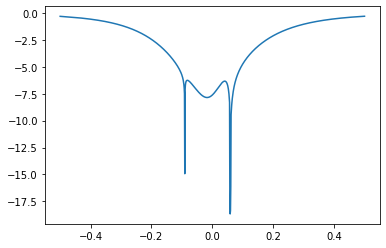

In [4]:
print(Y[5])
plt.plot(X_even[0, :, 0], X_even[5, :, 1])

# CDE Regression

In [5]:
from model.encoder_cde import CDEEncoder
import torchcde
import os

device = torch.device("cuda:8" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/experiment_4140.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

depth = 3; window_length = 10; window_length_rand = 2
train_logsig = torchcde.logsig_windows(X_even[:, :, :], depth, window_length=window_length)
train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(train_logsig)

output_dim = Y.shape[-1]
input_dim = train_logsig.shape[-1]
latent_dim = ckpt_args.latents

model = CDEEncoder(input_dim, latent_dim, output_dim).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

CDEEncoder(
  (cde_func): CDEFunc(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (relu1): ReLU()
    (resblocks): Sequential(
      (0): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): ReLU()
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): ReLU()
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (2): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): ReLU()
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
    )
    (relu2): ReLU()
    (linear2): Linear(in_features=1024, out_features=160, bias=True)
    (tanh): Tanh()
    (linear3): Linear(in_features=160, out_features=160, bias=True)
  )
  (initial): Sequential(
    (0): Sequential

In [6]:
from tqdm import tqdm
num = 4096*2
pred = torch.zeros((num, output_dim))
model.eval()
for i in tqdm(range(num // 128)):
    batch = train_coeffs[i*128:i*128+128].float().to(device)
    pred[i*128:i*128+128] = model(batch).detach().cpu()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [06:35<00:00,  6.18s/it]


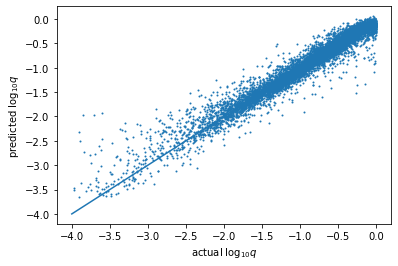

logq


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.xlabel(r'actual $\log_{10} q$')
plt.ylabel(r'predicted $\log_{10} q$')
plt.scatter(Y[:num, 0]/np.log(10), pred.numpy()[:num, 0]/np.log(10), s=1)
plt.plot(np.linspace(-4, 0), np.linspace(-4, 0))
plt.show()
print('logq')

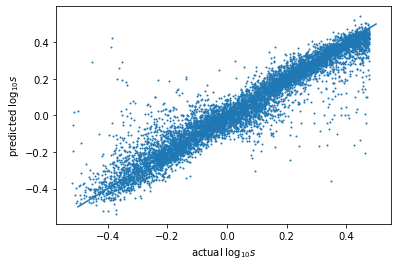

logs


In [8]:
plt.xlabel(r'actual $\log_{10} s$')
plt.ylabel(r'predicted $\log_{10} s$')
plt.scatter(Y[:num, 1]/np.log(10), pred.numpy()[:, 1]/np.log(10), s=1)
plt.plot(np.linspace(-0.5, 0.5), np.linspace(-0.5, 0.5))
plt.show()
print('logs')

In [9]:
torch.mean((Y[:num, 0] / np.log(10) - pred[:, 0] / np.log(10))**2)

tensor(0.0266, dtype=torch.float64)

In [10]:
# orig_sample_Y = Y[:num] * std_y + mean_y
# orig_sample_pred = pred.detach().cpu() * std_y + mean_y

In [11]:
# u0 = orig_sample_Y[:, 2]
# log10q = orig_sample_Y[:, 4] / np.log(10)
# log10s = orig_sample_Y[:, 5] / np.log(10)
# alpha = orig_sample_Y[:, 6]
# u0cosalpha = u0 * np.cos(alpha/180*np.pi)
# u0sinalpha = u0 * np.sin(alpha/180*np.pi)

log10q = Y[:num, 0] / np.log(10)
log10s = Y[:num, 1] / np.log(10)

# u0_pred = orig_sample_pred[:, 2]
# log10q_pred = orig_sample_pred[:, 4] / np.log(10)
# log10s_pred = orig_sample_pred[:, 5] / np.log(10)
# alpha_pred = orig_sample_pred[:, 6]
# u0cosalpha_pred = u0_pred * np.cos(alpha_pred/180*np.pi)
# u0sinalpha_pred = u0_pred * np.sin(alpha_pred/180*np.pi)
log10q_pred = pred[:num, 0] / np.log(10)
log10s_pred = pred[:num, 1] / np.log(10)

In [12]:
mse_log10q = torch.mean((log10q - log10q_pred)**2)
mse_log10s = torch.mean((log10s - log10s_pred)**2)
# mse_u0cos = torch.mean((u0cosalpha - u0cosalpha_pred)**2)
# mse_u0sin = torch.mean((u0sinalpha - u0sinalpha_pred)**2)
# mse_u0 = torch.mean((u0 - u0_pred)**2)
# mse_alpha = torch.mean((alpha - alpha_pred)**2)
print(f"mse of log10q: {mse_log10q}, mse of log10s: {mse_log10s}")
# print(f"mse of u0cos_alpha: {mse_u0cos}, mse of u0sin_alpha: {mse_u0sin}")
# print(f"mse of u0: {mse_u0}, mse of alpha: {mse_alpha}")

mse of log10q: 0.026588554829073824, mse of log10s: 0.005722853746863815


## irregular

In [13]:
with h5py.File('/work/hmzhao/irregular-lc/random-even-batch-1.h5', mode='r') as dataset_file:
    X_rand = torch.tensor(dataset_file['X_random'][...])

In [14]:
X_rand = X_rand[:, :, :2]
X_rand[:, :, 1] = (X_rand[:, :, 1] - mean_x_even) / std_x_even
X_rand[:, :, 0] = X_rand[:, :, 0] / 200
print(f'normalized X mean: {torch.mean(X_rand[:, :, 1])}\nX std: {torch.mean(torch.std(X_rand[:, :, 1], axis=0))}')

normalized X mean: -2.0694118612751304
X std: 1.2975609646921018


tensor([-1.1411, -0.4616], dtype=torch.float64)


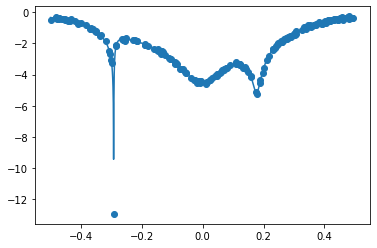

In [15]:
num = 1
print(Y[num])
plt.scatter(X_rand[num, :, 0], X_rand[num, :, 1])
plt.plot(X_even[num, :, 0], X_even[num, :, 1])

In [16]:
num = 4096*2
train_logsig_rand = torchcde.logsig_windows(X_rand[:num, :, :], depth, window_length=window_length_rand)
train_rand_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(train_logsig_rand)

In [17]:
pred_ir = torch.zeros((num, output_dim))
model.eval()
for i in tqdm(range(num // 128)):
    batch = train_rand_coeffs[i*128:i*128+128].float().to(device)
    pred_ir[i*128:i*128+128] = model(batch).detach().cpu()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [10:17<00:00,  9.65s/it]


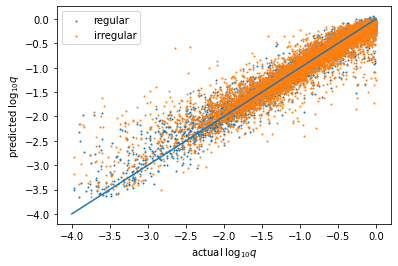

logq


In [18]:
plt.xlabel(r'actual $\log_{10} q$')
plt.ylabel(r'predicted $\log_{10} q$')
plt.scatter(Y[:num, 0]/np.log(10), pred.numpy()[:, 0]/np.log(10), label='regular', s=1)
plt.scatter(Y[:num, 0]/np.log(10), pred_ir.numpy()[:, 0]/np.log(10), label='irregular', s=1)
plt.plot(np.linspace(-4, 0), np.linspace(-4, 0))
plt.legend()
plt.show()
print('logq')

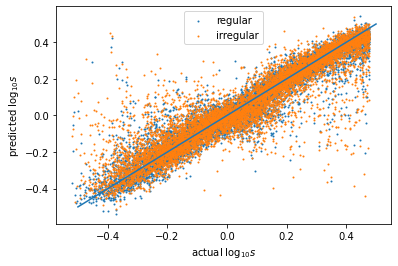

logs


In [19]:
plt.xlabel(r'actual $\log_{10} s$')
plt.ylabel(r'predicted $\log_{10} s$')
plt.scatter(Y[:num, 1]/np.log(10), pred.numpy()[:, 1]/np.log(10), label='regular', s=1)
plt.scatter(Y[:num, 1]/np.log(10), pred_ir.numpy()[:, 1]/np.log(10), label='irregular', s=1)
plt.plot(np.linspace(-0.5, 0.5), np.linspace(-0.5, 0.5))
plt.legend()
plt.show()
print('logs')

In [20]:
# orig_sample_pred_ir = pred_ir.detach().cpu() * std_y + mean_y

# u0_pred_ir = orig_sample_pred_ir[:, 2]
# log10q_pred_ir = orig_sample_pred_ir[:, 4] / np.log(10)
# log10s_pred_ir = orig_sample_pred_ir[:, 5] / np.log(10)
# alpha_pred_ir = orig_sample_pred_ir[:, 6]
# u0cosalpha_pred_ir = u0_pred_ir * np.cos(alpha_pred_ir/180*np.pi)
# u0sinalpha_pred_ir = u0_pred_ir * np.sin(alpha_pred_ir/180*np.pi)

log10q_pred_ir = pred_ir[:, 0] / np.log(10)
log10s_pred_ir = pred_ir[:, 1] / np.log(10)

In [21]:
mse_log10q_ir = torch.mean((log10q - log10q_pred_ir)**2)
mse_log10s_ir = torch.mean((log10s - log10s_pred_ir)**2)
# mse_u0cos_ir = torch.mean((u0cosalpha - u0cosalpha_pred_ir)**2)
# mse_u0sin_ir = torch.mean((u0sinalpha - u0sinalpha_pred_ir)**2)
# mse_u0_ir = torch.mean((u0 - u0_pred_ir)**2)
# mse_alpha_ir = torch.mean((alpha - alpha_pred_ir)**2)
print('regular:')
print(f"mse of log10q: {mse_log10q}, mse of log10s: {mse_log10s}")
# print(f"mse of u0cos_alpha: {mse_u0cos}, mse of u0sin_alpha: {mse_u0sin}")
# print(f"mse of u0: {mse_u0}, mse of alpha: {mse_alpha}")
print('irregular:')
print(f"mse of log10q: {mse_log10q_ir}, mse of log10s: {mse_log10s_ir}")
# print(f"mse of u0cos_alpha: {mse_u0cos_ir}, mse of u0sin_alpha: {mse_u0sin_ir}")
# print(f"mse of u0: {mse_u0_ir}, mse of alpha: {mse_alpha_ir}")

regular:
mse of log10q: 0.026588554829073824, mse of log10s: 0.005722853746863815
irregular:
mse of log10q: 0.055432783393957255, mse of log10s: 0.010354257673264413


Ground Truth: [-2.68066621  1.09161808]
Reg Pred [-3.0496705  1.1511258]
Reg MSE [0.02568214 0.00066791]
Irr Pred [-3.3076918  1.142445 ]
Irr MSE [0.07415475 0.00048725]


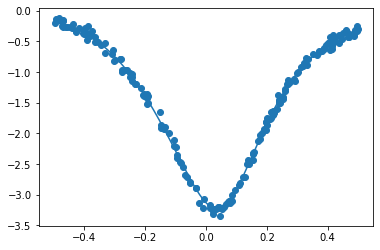

In [23]:
num = 0
print('Ground Truth:', Y[num].numpy())
print('Reg Pred', pred[num].numpy())
print('Reg MSE', ((Y[num]/np.log(10)- pred[num]/np.log(10))**2).numpy())
print('Irr Pred', pred_ir[num].numpy())
print('Irr MSE', ((Y[num]/np.log(10)- pred_ir[num]/np.log(10))**2).numpy())
plt.scatter(X_rand[num, :, 0], X_rand[num, :, 1])
plt.plot(X_even[num, :, 0], X_even[num, :, 1])

Ground Truth: [-0.49557534 -0.20045365]
Reg Pred [-0.47099546 -0.27160046]
Reg MSE [0.00060417 0.00506187]
Irr Pred [-0.4658182  -0.19291106]
Irr MSE [8.85487338e-04 5.68906624e-05]


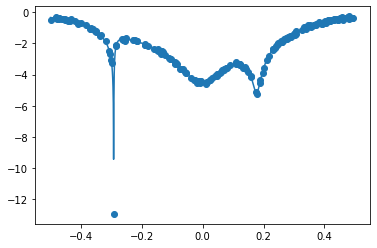

In [43]:
num = 1
print('Ground Truth:', Y[num].numpy()/np.log(10))
print('Reg Pred', pred[num].numpy()/np.log(10))
print('Reg MSE', ((Y[num]/np.log(10)- pred[num]/np.log(10))**2).numpy())
print('Irr Pred', pred_ir[num].numpy()/np.log(10))
print('Irr MSE', ((Y[num]/np.log(10)- pred_ir[num]/np.log(10))**2).numpy())
plt.scatter(X_rand[num, :, 0], X_rand[num, :, 1])
plt.plot(X_even[num, :, 0], X_even[num, :, 1])

In [35]:
torch.argmax(((Y[:4096*2] - pred)**2)[:,0])

tensor(6461)

Ground Truth: [-3.85518735 -0.0100205 ]
Reg Pred [-1.9737492  -0.10856807]
Reg MSE [3.53980966 0.00971162]
Irr Pred [-2.1837492   0.08654018]
Irr MSE [2.7937055  0.00932397]


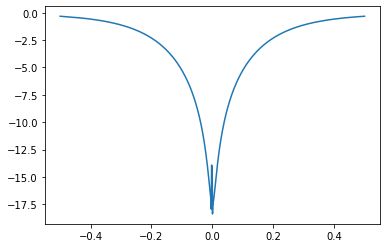

In [42]:
num = 6461
print('Ground Truth:', Y[num].numpy()/np.log(10))
print('Reg Pred', pred[num].numpy()/np.log(10))
print('Reg MSE', ((Y[num]/np.log(10)- pred[num]/np.log(10))**2).numpy())
print('Irr Pred', pred_ir[num].numpy()/np.log(10))
print('Irr MSE', ((Y[num]/np.log(10)- pred_ir[num]/np.log(10))**2).numpy())
# plt.scatter(X_rand[num, :, 0], X_rand[num, :, 1])
plt.plot(X_even[num, :, 0], X_even[num, :, 1])

In [38]:
torch.argmax(((Y[:4096*2] - pred)**2)[:,1])

tensor(5902)

Ground Truth: [-0.68716978 -0.38642364]
Reg Pred [-1.0063516   0.42163154]
Reg MSE [0.10187703 0.65295318]
Irr Pred [-1.2138722   0.43424177]
Irr MSE [0.27741543 0.67349171]


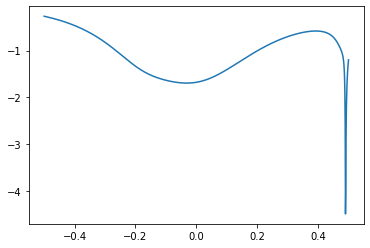

In [44]:
num = 5902
print('Ground Truth:', Y[num].numpy()/np.log(10))
print('Reg Pred', pred[num].numpy()/np.log(10))
print('Reg MSE', ((Y[num]/np.log(10)- pred[num]/np.log(10))**2).numpy())
print('Irr Pred', pred_ir[num].numpy()/np.log(10))
print('Irr MSE', ((Y[num]/np.log(10)- pred_ir[num]/np.log(10))**2).numpy())
# plt.scatter(X_rand[num, :, 0], X_rand[num, :, 1])
plt.plot(X_even[num, :, 0], X_even[num, :, 1])

# LZR's results
## mse on ideal

loss(mse): 0.1

log10q: 0.3^2=0.09, log10s: 0.18^2=0.0324

## mse on realistic

loss(mse): 0.1

log10q: 0.0846, log10s: 0.0176

u0cos: 0.037, u0sin: 0.040

u0: 0.0176, alpha: 7441.306

# Generative ODE

In [5]:
from model.gen_ode import GenODE

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
input_dim = Y.shape[-1]
output_dim = X_even.shape[-1] - 1

checkpt = torch.load('/work/hmzhao/experiments/experiment_91672.ckpt')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

model = GenODE(ckpt_args, input_dim, output_dim, device).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

GenODE(
  (aug_net): Sequential(
    (0): Sequential(
      (0): Linear(in_features=7, out_features=256, bias=True)
      (1): Tanh()
      (2): Linear(in_features=256, out_features=256, bias=True)
    )
    (1): ResBlock(
      (linear1): Linear(in_features=256, out_features=1024, bias=True)
      (nonlinear1): Tanh()
      (linear2): Linear(in_features=1024, out_features=256, bias=True)
      (nonlinear2): Tanh()
      (linear3): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): ResBlock(
      (linear1): Linear(in_features=256, out_features=1024, bias=True)
      (nonlinear1): Tanh()
      (linear2): Linear(in_features=1024, out_features=256, bias=True)
      (nonlinear2): Tanh()
      (linear3): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): ResBlock(
      (linear1): Linear(in_features=256, out_features=1024, bias=True)
      (nonlinear1): Tanh()
      (linear2): Linear(in_features=1024, out_features=256, bias=True)
      (nonlinear2): Tanh()

In [24]:
model.eval()
num = 9
pred = model(torch.tensor(Y[num].reshape(1, -1)).float().to(device), torch.tensor(X_even[0, :, 0]).float().to(device))

/var/tmp/pbs.76146.metis/ipykernel_2237054/2281277329.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = model(torch.tensor(Y[num].reshape(1, -1)).float().to(device), torch.tensor(X_even[0, :, 0]).float().to(device))


tensor([ 0.0000, 50.0000,  1.8059, -0.8079,  0.0583,  0.9828, -1.4816],
       dtype=torch.float64)


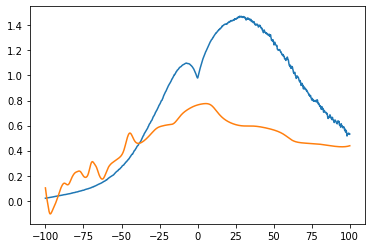

In [25]:
print(Y[num])
plt.plot(X_even[num, :, 0], X_even[num, :, 1])
plt.plot(X_even[num, :, 0], pred.detach().cpu().numpy().flatten())

In [26]:
latent = model.aug_net(torch.tensor(Y[num].reshape(1, -1)).float().to(device))
print(latent)

tensor([[ 0.3719,  0.5745, -0.5689, -0.7571, -0.3540, -0.3572, -0.5003,  0.0472,
         -0.4456, -0.8231,  0.0650, -0.1645, -0.0868, -0.0801,  0.0713,  0.4275,
          0.1516,  0.3267, -0.3136, -0.2969,  0.2027, -0.5207, -0.5530,  0.4291,
          0.1795,  0.7403,  0.0014,  0.6046, -0.4481, -0.0197,  0.3870,  0.1702]],
       device='cuda:2', grad_fn=<TanhBackward>)


/var/tmp/pbs.76146.metis/ipykernel_2237054/3264624822.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latent = model.aug_net(torch.tensor(Y[num].reshape(1, -1)).float().to(device))


In [27]:
initial_grad = model.ode_func(torch.tensor(-100).to(device), model.aug_net(torch.tensor(Y[num].reshape(1, -1)).float().to(device)))
print(initial_grad)

tensor([[ 0.6530, -0.0379, -0.8157, -0.6468, -0.0016,  0.4780, -0.6244,  0.7381,
         -0.3112, -0.7349, -0.6113, -0.1776,  0.2895,  0.5952,  0.1046, -0.0942,
          0.5388,  0.1250, -0.4205, -0.4357,  0.1152, -0.4637,  0.3835, -0.2316,
         -0.0043,  0.0744,  0.5310, -0.1046,  0.2542,  0.4332, -0.1092,  0.8952]],
       device='cuda:2', grad_fn=<TanhBackward>)


/var/tmp/pbs.76146.metis/ipykernel_2237054/837117711.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_grad = model.ode_func(torch.tensor(-100).to(device), model.aug_net(torch.tensor(Y[num].reshape(1, -1)).float().to(device)))


In [28]:
from torchdiffeq import odeint
sol = odeint(model.ode_func, latent, torch.tensor(X_even[0, :, 0]).float().to(device), method="dopri5",
            rtol=1e-7, atol=1e-9)

/var/tmp/pbs.76146.metis/ipykernel_2237054/3534019619.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sol = odeint(model.ode_func, latent, torch.tensor(X_even[0, :, 0]).float().to(device), method="dopri5",


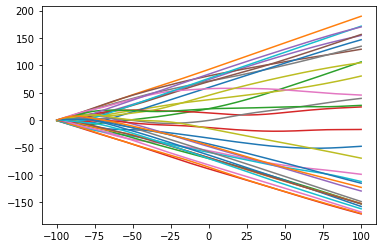

In [29]:
plt.plot(X_even[0, :, 0], sol.squeeze(1).detach().cpu())
plt.show()